In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorboard.plugins.hparams import api as hp

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np
import pathlib
import PIL
import datetime

In [ ]:
# Connect if you are running the notebook on Google Colaboratory and the dataset is on Google Drive
from google.colab import drive
drive.mount('/content/drive')

## Input pipeline

In [3]:
# Path for Google Colab (alter it accoring to your folder structure, if running on colaboratory)

# GOOGLE DRIVE
# DATASET_DIR = "/content/drive/MyDrive/Colab_Notebooks/SSOC/Blood_Disease_Detection/Datasets/dataset2-master/dataset2-master/images"

# KAGGLE
DATASET_DIR = "../input/blood-cells/dataset2-master/dataset2-master/images/"

# LOCAL
# DATASET_DIR = os.path.join("..", "Datasets", "dataset2-master", "dataset2-master", "images")

TRAINING_DIR = os.path.join(DATASET_DIR, "TRAIN")
TESTING_DIR = os.path.join(DATASET_DIR, "TEST")
SIMPLE_TEST_DIR = os.path.join(DATASET_DIR, "TEST_SIMPLE")

In [4]:
training = pathlib.Path(TRAINING_DIR)
testing = pathlib.Path(TESTING_DIR)
simple_testing = pathlib.Path(SIMPLE_TEST_DIR)
training_images_count = len(list(training.glob("*/*.jpeg")))
testing_images_count = len(list(testing.glob("*/*.jpeg")))
simple_test_count = len(list(simple_testing.glob("*/*.jpeg")))

print(f"Number of Training Images = {training_images_count}")
print(f"Number of Testing Images = {testing_images_count}")
print(f"Number of Simple Testing Images = {simple_test_count}")


Number of Training Images = 9957
Number of Testing Images = 2487
Number of Simple Testing Images = 71


In [5]:
class_names = os.listdir(TRAINING_DIR)
class_names

['MONOCYTE', 'NEUTROPHIL', 'LYMPHOCYTE', 'EOSINOPHIL']

In [6]:
BATCH_SIZE = 32
temp_img_path = os.path.join(TRAINING_DIR, "EOSINOPHIL", "_0_207.jpeg")
IMG_HEIGHT = PIL.Image.open(temp_img_path).height
IMG_WIDTH = PIL.Image.open(temp_img_path).width

print(f"Image dimentions = {IMG_WIDTH}x{IMG_HEIGHT}")
print(f"Batch Size = {BATCH_SIZE}")

Image dimentions = 320x240
Batch Size = 32


In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAINING_DIR,
    labels = "inferred",
    # label_mode = "int",
    validation_split = 0.2,
    subset = "training",
    shuffle = True,
    seed = 69,
    image_size = (IMG_WIDTH, IMG_HEIGHT),
    batch_size = BATCH_SIZE,
    color_mode = "rgb"
)

Found 9957 files belonging to 4 classes.
Using 7966 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAINING_DIR,
    labels = "inferred",
    # label_mode = "int",
    validation_split = 0.2,
    subset = "validation",
    shuffle = True,
    seed = 69,
    image_size = (IMG_WIDTH, IMG_HEIGHT),
    batch_size = BATCH_SIZE,
    color_mode = "rgb"   
)

Found 9957 files belonging to 4 classes.
Using 1991 files for validation.


In [9]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    TESTING_DIR,
    labels="inferred",
    shuffle=True,
    seed = 69,
    image_size = (IMG_WIDTH, IMG_HEIGHT),
    batch_size = BATCH_SIZE,
    color_mode = "rgb"
)

Found 2487 files belonging to 4 classes.


## Visualizing

MONOCYTE


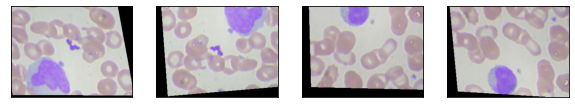

NEUTROPHIL


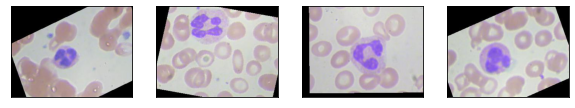

LYMPHOCYTE


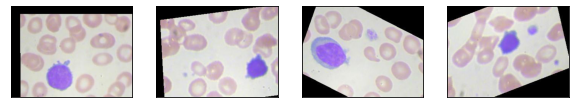

EOSINOPHIL


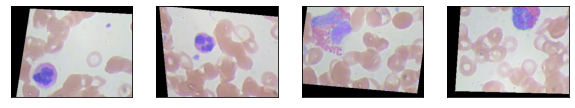

In [10]:
for name in class_names:
    subdir = os.path.join(TRAINING_DIR, name)
    images = os.listdir(subdir)
    fig = plt.figure(num=name, figsize=(10, 10))
    print(name)
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = mpimg.imread(os.path.join(subdir, images[i]))
        plt.imshow(img)
    plt.show()

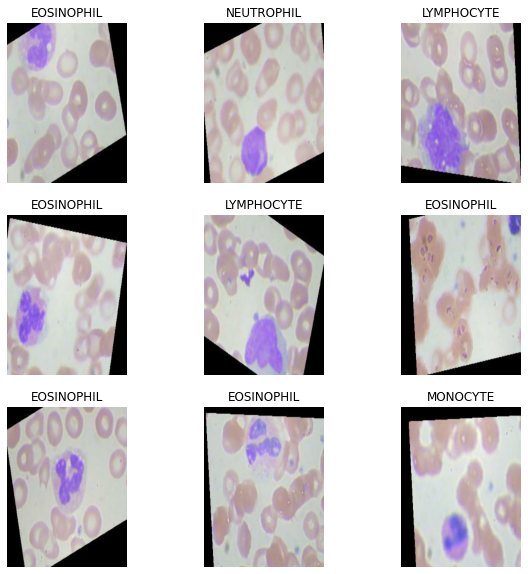

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    break

## Important Functions

In [12]:
def normalizeDataset(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

In [14]:
def cacheAndOptimizeDataset(dataset, dataset_cache_file_path):
    AUTOTUNE = tf.data.AUTOTUNE                                         # AUTOTUNE decides that how many batches will be read by the CPU while the GPU is running the current batch
    NUM_THREADS = 4

#     dataset = dataset.map(normalizeDataset)
    dataset = dataset.cache(dataset_cache_file_path)                    # .cache caches the dataset in RAM. 
    dataset = dataset.batch(BATCH_SIZE)                                 # .batch specifies the batch size to be prefetched
    dataset = dataset.prefetch(AUTOTUNE)                                # .prefetch specifies how many batches to are to be loaded prior by the CPU
    dataset = dataset.shuffle(10000, reshuffle_each_iteration=True)      # .shuffle shuffles it with a buffer of 5000 elements.
    return dataset

# I've used CPU and GPU example above make it easy to understand what prefetch is for. Actual scenario may vary depending on your computer.

In [15]:
def initializeTensorBoardSession():
    %load_ext tensorboard

def uploadLogsToTensorboard(log_dir, name):
    !tensorboard dev upload \
        --logdir $log_dir \
        --name $name \
        --one_shot \

In [16]:
def clearLogFile(log_file_path):
    open(log_file_path, 'w').close()

def callbackLogger(log_file_path, batch, logs):
    """ Logs the training accuracy and loss in the logs.txt file, present in log_file_path """
    with open(log_file_path, "a+") as f:
        f.write(f"Batch - {batch} {logs}\n")

In [17]:
def makeModel(optimizer, loss_fn, num_classes):
    """ Makes and returns the model based on the passed parameters """

    model = Sequential([
        layers.Rescaling(1./255, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        layers.Conv2D(32, 3, padding='same', activation="relu"),
        layers.MaxPool2D(),
        layers.Conv2D(64, 3, padding='same', activation="relu"),
        layers.MaxPool2D(),
        layers.Conv2D(64, 3, padding='same', activation="relu"),
        layers.MaxPool2D(),
        layers.Conv2D(32, 3, padding='same', activation="relu"),
        layers.MaxPool2D(),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_classes)
    ])

    model.compile(
        optimizer = optimizer,
        loss = loss_fn,
        metrics = ['accuracy']
    )

    return model

## Running the model

In [18]:
# GOOGLE COLAB
# DATASET_CACHE_FILE_PATH = "/content/drive/MyDrive/Colab_Notebooks/SSOC/Blood_Disease_Detection/Runtime/"
# LOG_FILE_PATH = "/content/drive/MyDrive/Colab_Notebooks/SSOC/Blood_Disease_Detection/Runtime/logs.txt"
# TENSORBOARD_LOG_DIR = "/content/drive/MyDrive/Colab_Notebooks/SSOC/Blood_Disease_Detection/Runtime/"

# KAGGLE
TENSORBOARD_LOG_DIR = os.path.join(".", "Runtime", "")
LOG_FILE_PATH = os.path.join(".", "Runtime", "logs.txt")
DATASET_CACHE_FILE_PATH = os.path.join(".", "Runtime", "")

# LOCAL
# LOG_FILE_PATH = os.path.join(".", "Runtime", "logs.txt")
# DATASET_CACHE_FILE_PATH = os.path.join(".", "Runtime", "")
# TENSORBOARD_LOG_DIR = os.path.join(".", "Runtime", "")

In [19]:
if "Runtime" not in os.listdir("."):
    print("MAKING Runtime DIRECTORY")
    os.mkdir("Runtime")

# Arguments in python are pass by reference hence the original datasets (train_ds, val_ds, test_ds) will be modified
cacheAndOptimizeDataset(train_ds, DATASET_CACHE_FILE_PATH)
cacheAndOptimizeDataset(val_ds, DATASET_CACHE_FILE_PATH)
cacheAndOptimizeDataset(test_ds, DATASET_CACHE_FILE_PATH)
NUM_CLASSES = len(class_names)

MAKING Runtime DIRECTORY


### Test Optimizer

In [25]:
epochs = 15
histories = []

hyperparameters = [
    {"loss": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "activation": "relu", "optimizer": "sgd"},
    {"loss": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "activation": "relu", "optimizer": "adagrad"},
    {"loss": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "activation": "relu", "optimizer": "rmsprop"},
    {"loss": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "activation": "relu", "optimizer": "adadelta"},
    {"loss": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "activation": "relu", "optimizer": "adam"},
]

clearLogFile(LOG_FILE_PATH)
initializeTensorBoardSession()

for parameter in hyperparameters:
    optimizer = parameter["optimizer"]
    loss_fn = parameter["loss"]
    activation_fn = parameter["activation"]
    model = makeModel(optimizer, loss_fn, NUM_CLASSES)

    log_name = f"SSOC_Blood_Disease__Optimizer:{optimizer}__loss:{loss_fn.name}__activation:{activation_fn}"
    print("~"*150)
    print(log_name)
    print("~"*150, end="\n\n")
    
    # DEFINING THE CALLBACKS
    basic_info_log_callback = tf.keras.callbacks.LambdaCallback(on_batch_end = lambda batch, logs: callbackLogger(LOG_FILE_PATH, batch, logs))
    current_timestamp = datetime.datetime.now().strftime('%d_%m_%y %I:%M:%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir = os.path.join(TENSORBOARD_LOG_DIR, f"{optimizer}_{loss_fn.name}_{activation_fn}_{current_timestamp}"),  # this is the name of the folder for your current model
        histogram_freq = 1
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        batch_size = BATCH_SIZE,
        callbacks=[tensorboard_callback]
    )
    
    # Uncomment if running on colab
    # uploadLogsToTensorboard(TENSORBOARD_LOG_DIR, log_name)

    histories.append(history)
    print()
    print("~"*150)
    print()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
SSOC_Blood_Disease__Optimizer:sgd__loss:sparse_categorical_crossentropy__activation:relu
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1/15
249/249 [==============================] - 36s 141ms/step - loss: 1.3875 - accuracy: 0.2452 - val_loss: 1.3863 - val_accuracy: 0.2526
Epoch 2/15
249/249 [==============================] - 18s 69ms/step - loss: 1.3864 - accuracy: 0.2486 - val_loss: 1.3861 - val_accuracy: 0.2501
Epoch 3/15
249/249 [==============================] - 18s 72ms/step - loss: 1.3863 - accuracy: 0.2540 - val_loss: 1.3862 - val_accuracy: 0.2496
Epoch 4/15
249/249 [==============================] - 18s 72ms/step - loss: 1.3861 - 

In [26]:
# Run if you want to download the training and validation logs from a single file
import shutil
shutil.make_archive("Runtime", 'zip', "./Runtime")

'/kaggle/working/Runtime.zip'

In [ ]:
# RUN this in console 
tensorboard dev upload --logdir . --name "Optimizer Efficiency (15 Epochs)" --one_shot

In [ ]:
for directory in os.listdir("./Runtime"):
    possible_dir = f"./Runtime/{directory}/"
    if os.path.isdir(possible_dir):
        print(f"deleting {possible_dir}")
        shutil.rmtree(f"./Runtime/{directory}/")
os.remove("./Runtime.zip")

In [ ]:
# RUN WHEN YOU GET UnimplementedError: Graph execution error: DNN library is not found on GOOGLE COLAB

# Check libcudnn8 version
!apt-cache policy libcudnn8

# Install latest version
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

# Export env variables
!export PATH=/usr/local/cuda-11.4/bin${PATH:+:${PATH}}
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/lib64:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/include:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda/extras/CUPTI/lib64

# Install tensorflow
!pip install tflite-model-maker==0.4.0
!pip uninstall -y tensorflow && pip install -q tensorflow==2.9.1
!pip install pycocotools==2.0.4
!pip install opencv-python-headless==4.6.0.66